In [110]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter,MultipleLocator
import matplotlib.colors as mcolors

In [111]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


In [112]:
def _clean_num(s):
    # handle "*", "-", commas, blanks → numeric
    return (s.astype(str)
              .str.strip()
              .replace({"*": np.nan, "-": 0, "": np.nan})
              .str.replace(",", "", regex=False)
              .pipe(pd.to_numeric, errors="coerce"))

In [ ]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })

In [114]:
def load_table4_2023_all_regions(path_xlsx: str) -> pd.DataFrame:
    """
    Combine all region sheets for the 2023 workbook.
    - Region name from cell A2 on each sheet
    - Data range: rows 4–24, columns A,D,G,J,M
    - Returns tidy df with columns:
      ['Year','Region','Broad Industry Group',
       'All_FT_employees','All_PT_employees',
       'All_total_employees','All_total_employment']
    """
    xl = pd.ExcelFile(path_xlsx)
    frames = []
    skip_re = re.compile(r"(?i)information|contents|cover|readme|about")

    for sh in xl.sheet_names:
        if skip_re.search(sh or ""):
            continue

        # --- 1) Get region from A2
        reg_df = pd.read_excel(path_xlsx, sheet_name=sh, header=None, nrows=2, usecols="A")
        region = str(reg_df.iat[1, 0]).strip() if reg_df.shape[0] >= 2 else sh.strip()

        # --- 2) Read the required block: rows 4–24, cols A,D,G,J,M
        # rows are 1-indexed in Excel, so skip first 3 rows, then read 21 rows
        block = pd.read_excel(
            path_xlsx,
            sheet_name=sh,
            header=None,
            usecols="A,D,G,J,M",
            skiprows=3,   # skip rows 1–3
            nrows=21      # rows 4–24 inclusive
        )

        block.columns = [
            "Broad Industry Group",
            "All_FT_employees",
            "All_PT_employees",
            "All_total_employees",
            "All_total_employment",
        ]

        # Drop empty rows (sometimes trailing notes bleed in)
        block["Broad Industry Group"] = block["Broad Industry Group"].astype(str).str.strip()
        block = block[block["Broad Industry Group"].ne("") & block["Broad Industry Group"].ne("nan")].copy()

        # Clean numeric columns
        for c in ["All_FT_employees","All_PT_employees","All_total_employees","All_total_employment"]:
            block[c] = _clean_num(block[c])

        # Tag region/year
        block["Region"] = region
        block["Year"] = 2023

        frames.append(block)

    if not frames:
        return pd.DataFrame(columns=[
            "Year","Region","Broad Industry Group",
            "All_FT_employees","All_PT_employees",
            "All_total_employees","All_total_employment"
        ])

    df = pd.concat(frames, ignore_index=True)

    # Optional: remove obvious header echoes if any slipped through
    drop_patterns = re.compile(r"(?i)source:|notes?$|key$|reference year|thousand")
    df = df[~df["Broad Industry Group"].str.contains(drop_patterns, na=False)].copy()

    # Order columns nicely
    df = df[
        ["Year","Region","Broad Industry Group",
         "All_FT_employees","All_PT_employees",
         "All_total_employees","All_total_employment"]
    ]

    return df

In [ ]:
# path to your 2023 workbook
path = "../data/ons-table-4/table42023rv2.xlsx"   # <- update if needed
df_2023 = load_table4_2023_all_regions(path)

# quick peek
print(df_2023.shape)
print(df_2023.head(20).to_string(index=False))


(216, 7)
 Year     Region                         Broad Industry Group  All_FT_employees  All_PT_employees  All_total_employees  All_total_employment
 2023 North East              Agriculture, Forestry & Fishing               3.0               0.9                  3.9                  12.7
 2023 North East                Mining, Quarrying & Utilities              14.2               1.6                 15.8                  15.8
 2023 North East                                Manufacturing             100.9               9.7                110.7                 111.8
 2023 North East                                 Construction              46.6               8.8                 55.4                  58.2
 2023 North East                                 Motor Trades              10.7               1.6                 12.3                  12.6
 2023 North East                                    Wholesale              19.4               2.3                 21.7                  22.0
 202

In [116]:
def plot_mix_by_region_stacked_pct(df, out_basename="chart8_mix_by_region", chart_dir="chart-8",
                                   value_col="All_total_employment",
                                   region_order=None, big_order=None, palette=None):
    
    publication_rc()
    d = df.copy()
    # total per region
    tots = d.groupby("Region", as_index=False)[value_col].sum().rename(columns={value_col:"RegionTotal"})
    d = d.merge(tots, on="Region", how="left")
    # d["Pct"] = 100 * d[value_col] / d["RegionTotal"]

    d["Pct"] = d["RegionTotal"]

    # orders
    if region_order is None:
        # order regions by total employment descending
        region_order = (tots.sort_values("RegionTotal", ascending=False)["Region"].tolist())
    if big_order is None:
        # order BIGs by total across all regions
        big_order = (d.groupby("Broad Industry Group", as_index=False)[value_col]
                     .sum().sort_values(value_col, ascending=False)["Broad Industry Group"].tolist())

    pvt = (d.pivot_table(index="Region", columns="Broad Industry Group", values="Pct", aggfunc="sum")
             .reindex(index=region_order, columns=big_order).fillna(0))

    # colors
    if palette is None:
        # readable categorical palette (12). Extend if needed.
        palette = [
            "#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F","#EDC948",
            "#B07AA1","#FF9DA7","#9C755F","#BAB0AC","#8FBBD9","#C7E9C0"
        ]
    colors = {c: palette[i % len(palette)] for i, c in enumerate(pvt.columns)}

    fig_w = max(12, 0.75*len(pvt.index))
    fig, ax = plt.subplots(figsize=(fig_w, 6))

    bottom = np.zeros(len(pvt.index))
    x = np.arange(len(pvt.index))
    for col in pvt.columns:
        vals = pvt[col].values
        ax.bar(x, vals, bottom=bottom, label=col, color=colors[col])
        bottom += vals

    ax.set_title("Regional Employment Mix by Broad Industry Group (2023)", pad=12, fontweight="bold")
    ax.set_ylabel("Share of regional employment (Thousands)", fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(pvt.index, rotation=30, ha="right")
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    
    # ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.6)
    ax.grid(True, which="minor", axis="y", linestyle=":",  alpha=0.2)
    ax.yaxis.set_major_locator(MultipleLocator(5000))
    ax.yaxis.set_minor_locator(MultipleLocator(1000))
    ax.legend(title="Broad Industry Group", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    plt.tight_layout()
    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


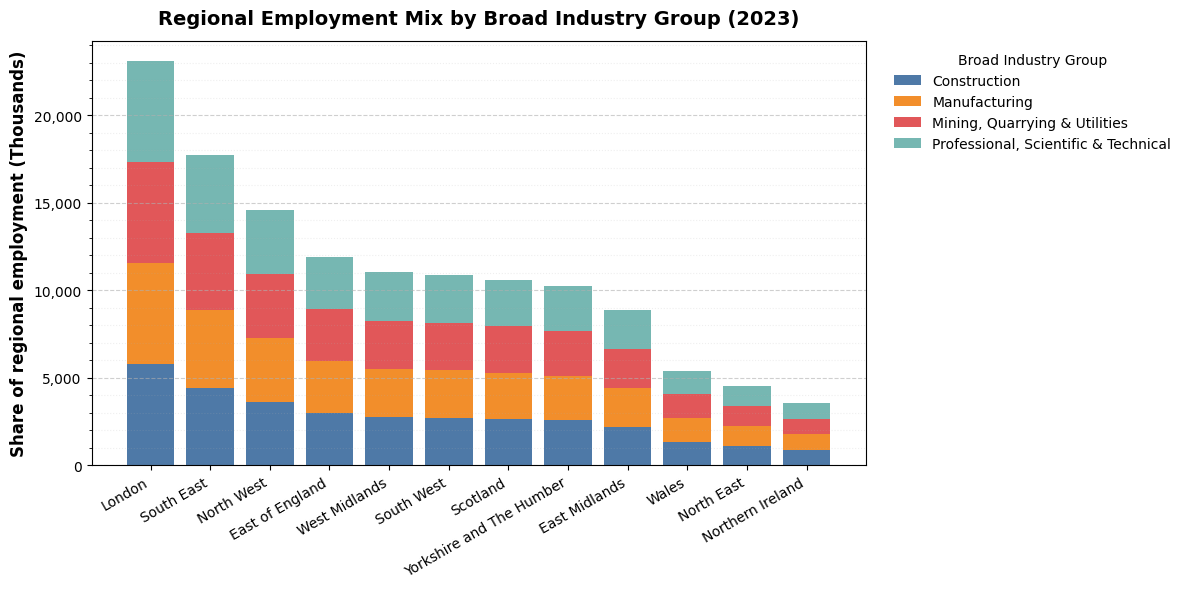

In [117]:
big_order_ = ["Construction",
              "Manufacturing",
              "Mining, Quarrying & Utilities",
              "Professional, Scientific & Technical",
             ]
plot_mix_by_region_stacked_pct(df_2023, value_col="All_total_employment", 
                               region_order=None, big_order=big_order_, palette=None)

In [118]:
def plot_heatmap_region_big(df, value_col="All_total_employment",
                            normalize_by_region=False,
                            out_basename="chart8_heatmap", chart_dir="chart-8",
                            cmap="Blues"):
    
    publication_rc()
    d = df.copy()

    if normalize_by_region:
        # convert to % share within region
        reg_tot = d.groupby("Region", as_index=False)[value_col].sum().rename(columns={value_col:"Rtot"})
        d = d.merge(reg_tot, on="Region", how="left")
        d["Value"] = 100 * d[value_col] / d["Rtot"]
        zlabel = "Share within region (%)"
    else:
        d["Value"] = d[value_col]
        zlabel = "Employment (thousands)"

    # orders: regions by total, BIG by overall size
    reg_order = (d.groupby("Region", as_index=False)["Value"].sum()
                   .sort_values("Value", ascending=False)["Region"].tolist())
    big_order = (d.groupby("Broad Industry Group", as_index=False)["Value"].sum()
                   .sort_values("Value", ascending=False)["Broad Industry Group"].tolist())

    pvt = (d.pivot_table(index="Region", columns="Broad Industry Group", values="Value", aggfunc="sum")
             .reindex(index=reg_order, columns=big_order).fillna(0))

    fig_w = max(12, 0.45*len(pvt.columns))
    fig_h = max(6, 0.45*len(pvt.index))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(pvt.values, aspect="auto", cmap=cmap)

    ax.set_title("Employment by Region and Broad Industry Group (2023)", pad=12, fontweight="bold")
    ax.set_yticks(np.arange(len(pvt.index)))
    ax.set_yticklabels(pvt.index)
    ax.set_xticks(np.arange(len(pvt.columns)))
    ax.set_xticklabels(pvt.columns, rotation=45, ha="right")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(zlabel)

    plt.tight_layout()
    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


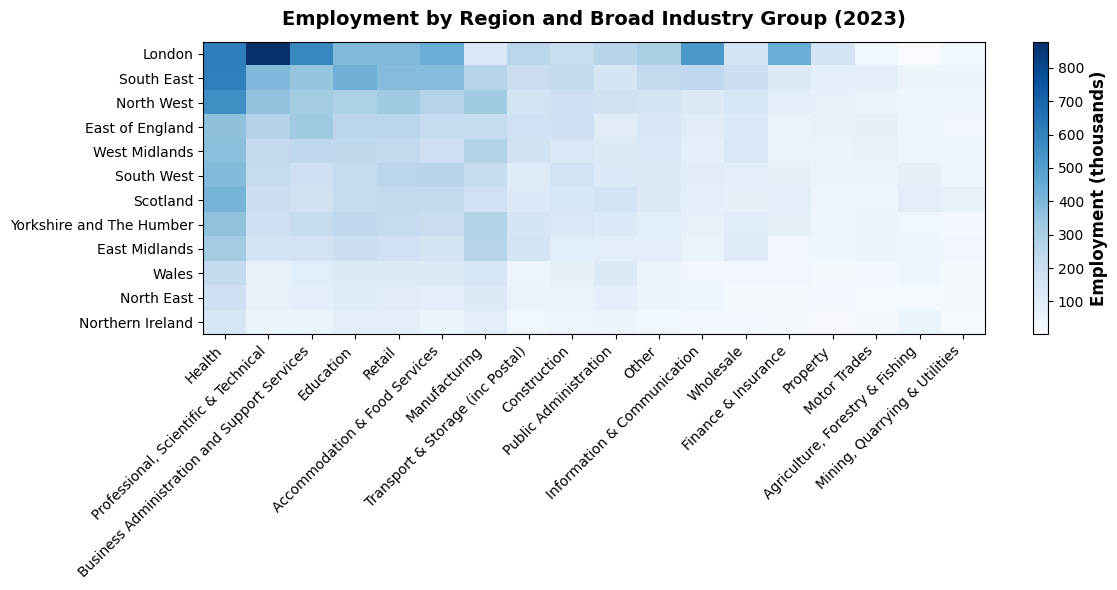

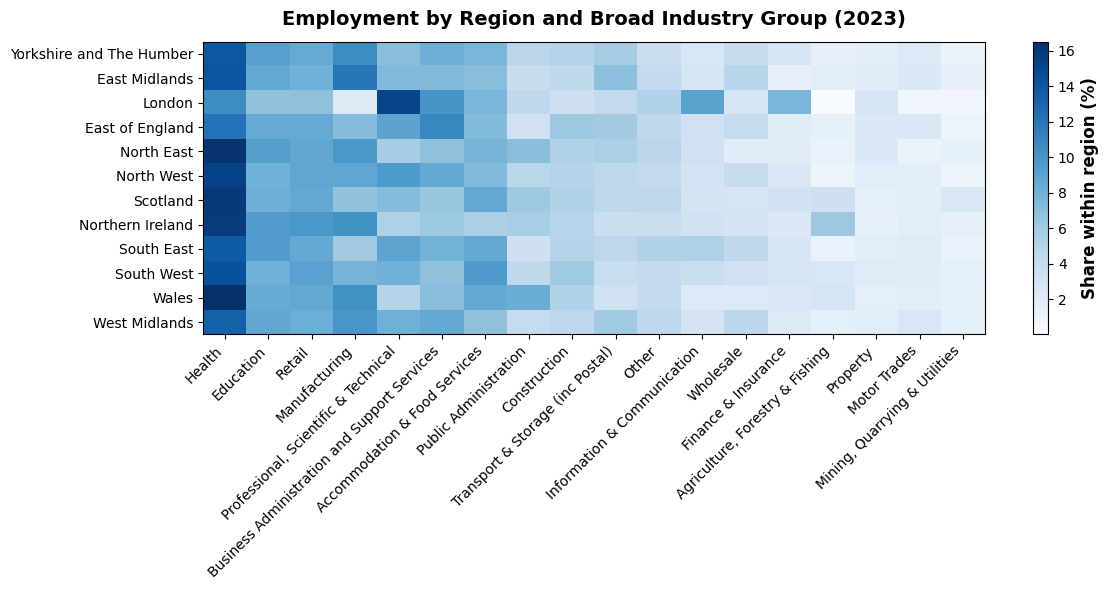

In [119]:
plot_heatmap_region_big(df_2023, value_col="All_total_employment", normalize_by_region=False,
                        out_basename="heatmap_abs")
plot_heatmap_region_big(df_2023, value_col="All_total_employment", normalize_by_region=True,
                        out_basename="heatmap_share")


In [120]:


def plot_heatmap_region_big(
    df,
    value_col="All_total_employment",
    normalize_by_region=False,
    out_basename="chart8_heatmap",
    chart_dir="chart-8",
    cmap="YlGnBu",                # richer multi-hue colormap
    annotate=True,                # write values in cells
    fmt_percent="{x:.0f}%",       # used when normalize_by_region=True
    fmt_number="{x:,.0f}",        # used when normalize_by_region=False
):
    publication_rc()
    d = df.copy()

    if normalize_by_region:
        reg_tot = (d.groupby("Region", as_index=False)[value_col]
                     .sum().rename(columns={value_col:"Rtot"}))
        d = d.merge(reg_tot, on="Region", how="left")
        d["Value"] = 100 * d[value_col] / d["Rtot"]
        zlabel = "Share within region (%)"
        fmt = fmt_percent
    else:
        d["Value"] = d[value_col]
        zlabel = "Employment (thousands)"
        fmt = fmt_number

    # orders
    reg_order = (d.groupby("Region", as_index=False)["Value"].sum()
                   .sort_values("Value", ascending=False)["Region"].tolist())
    big_order = (d.groupby("Broad Industry Group", as_index=False)["Value"].sum()
                   .sort_values("Value", ascending=False)["Broad Industry Group"].tolist())

    pvt = (d.pivot_table(index="Region", columns="Broad Industry Group",
                         values="Value", aggfunc="sum")
             .reindex(index=reg_order, columns=big_order)
             .fillna(0))

    # Figure size scales with table shape
    fig_w = max(12, 0.45 * len(pvt.columns))
    fig_h = max(6,  0.45 * len(pvt.index))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # Colormap and normalization (global vmin/vmax for consistent color scale)
    vmin, vmax = float(np.nanmin(pvt.values)), float(np.nanmax(pvt.values))
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    im = ax.imshow(pvt.values, aspect="auto", cmap=cmap, norm=norm)

    # Axes/labels
    ax.set_title("Employment by Region and Broad Industry Group (2023)",
                 pad=12, fontweight="bold")
    ax.set_yticks(np.arange(len(pvt.index)))
    ax.set_yticklabels(pvt.index)
    ax.set_xticks(np.arange(len(pvt.columns)))
    ax.set_xticklabels(pvt.columns, rotation=45, ha="right")

    # Thin gridlines to separate cells
    ax.set_xticks(np.arange(-.5, len(pvt.columns), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(pvt.index), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=0.8)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(zlabel)

    # Optional annotations with auto-contrast text color
    if annotate:
        cm = plt.cm.get_cmap(cmap)
        for i in range(pvt.shape[0]):
            for j in range(pvt.shape[1]):
                val = pvt.iat[i, j]
                # Choose white text on dark, black on light
                rgba = cm(norm(val))
                # Perceived luminance
                luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
                txt_color = "black" if luminance > 0.6 else "white"
                ax.text(j, i, fmt.format(x=val),
                        ha="center", va="center", fontsize=9, color=txt_color)

    plt.tight_layout()
    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


C:\Users\faith.SCCNIG\AppData\Local\Temp\ipykernel_222576\4294376674.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(cmap)


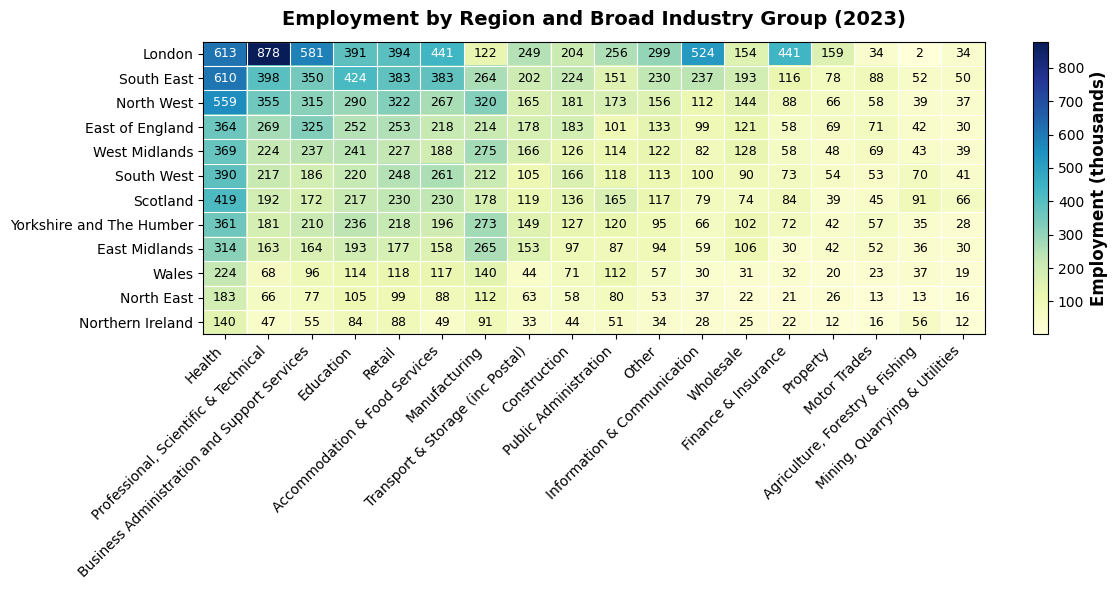

C:\Users\faith.SCCNIG\AppData\Local\Temp\ipykernel_222576\4294376674.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(cmap)


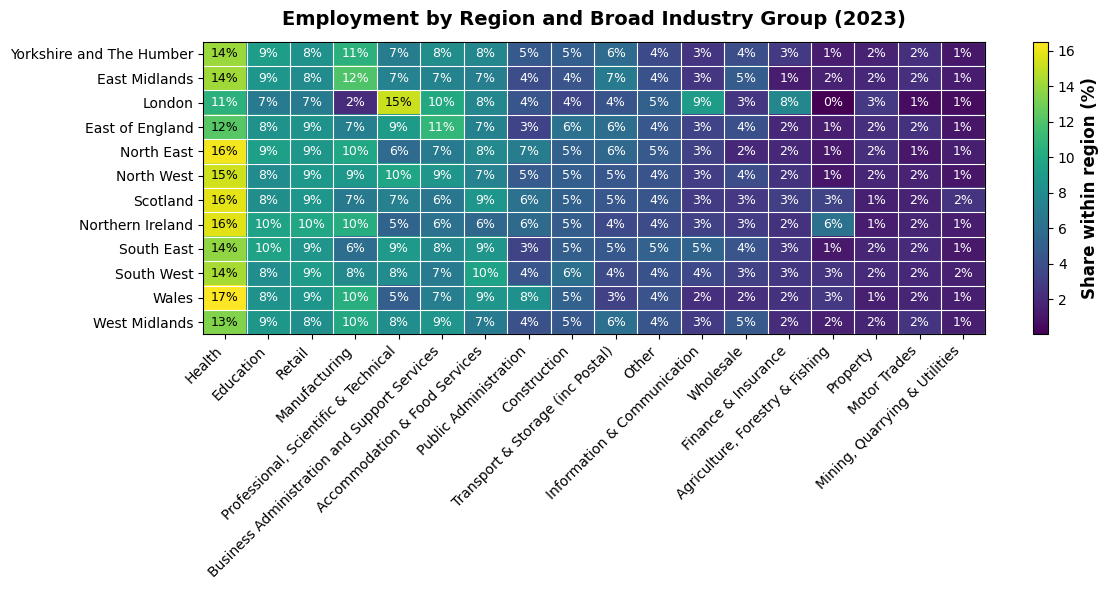

In [121]:
# Absolute employment (thousands), colored with YlGnBu
plot_heatmap_region_big(df_2023, value_col="All_total_employment",
                        normalize_by_region=False,
                        out_basename="heatmap_abs_2023", cmap="YlGnBu")

# Shares within region (%), colored with Viridis
plot_heatmap_region_big(df_2023, value_col="All_total_employment",
                        normalize_by_region=True,
                        out_basename="heatmap_share_2023", cmap="viridis")


In [122]:
# def plot_ft_pt_100_stack(df_2023,
#                          region=None,            
#                          top_n=None,
#                          out_basename="chart9_ftpt_100",
#                          chart_dir="chart-8",
#                          colors=("lightblue", "lightgrey")):
#     """
#     100% stacked bars of Full-time vs Part-time by Broad Industry Group (2023).
#     If region is None, aggregates across all regions; else filters to one region.
#     """

#     publication_rc()
#     d = df_2023.copy()

#     # Filter region if provided
#     if region:
#         d = d[d["Region"].eq(region)].copy()

#     # Aggregate to BIG level
#     grp = (d.groupby("Broad Industry Group", as_index=False)
#              .agg(FT=("All_FT_employees", "sum"),
#                   PT=("All_PT_employees", "sum"),
#                   Tot=("All_total_employees", "sum")))

#     # Optional: keep only top_n by total employment
#     if top_n:
#         keep = (grp.sort_values("Tot", ascending=False)
#                   .head(int(top_n))["Broad Industry Group"])
#         grp = grp[grp["Broad Industry Group"].isin(keep)]

#     # Compute % composition
#     grp["FT_pct"] = 100 * grp["FT"] / grp["Tot"].replace(0, np.nan)
#     grp["PT_pct"] = 100 * grp["PT"] / grp["Tot"].replace(0, np.nan)

#     # Order industries by total (desc) for a nice ladder look
#     grp = grp.sort_values("Tot", ascending=True)

#     # Plot
#     fig_h = max(6, 0.35 * len(grp))
#     fig, ax = plt.subplots(figsize=(12, fig_h))

#     y = np.arange(len(grp))
#     ax.barh(y, grp["FT_pct"].values, color=colors[0], label="Full-time")
#     ax.barh(y, grp["PT_pct"].values, left=grp["FT_pct"].values,
#             color=colors[1], label="Part-time")

#     ax.set_yticks(y)
#     ax.set_yticklabels(grp["Broad Industry Group"])
#     title_region = region if region else "All regions"
#     ax.set_title(f"Full-time vs Part-time Composition by Industry (2023) – {title_region}",
#                  pad=12, fontweight="bold")

#     ax.set_xlabel("Share of employees (%)", labelpad=8, fontweight="bold")
#     ax.set_xlim(0, 100)
#     ax.grid(True, axis="x", linestyle="--", alpha=0.4)
#     ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False)

#     # Optional in-bar labels (light)
#     for i, (ft, pt) in enumerate(zip(grp["FT_pct"].values, grp["PT_pct"].values)):
#         if ft > 6:
#             ax.text(ft/2, i, f"{ft:.0f}%", va="center", ha="center", color="black", fontsize=9)
#         if pt > 6:
#             ax.text(ft + pt/2, i, f"{pt:.0f}%", va="center", ha="center", color="black", fontsize=9)

#     plt.tight_layout()
#     save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


In [123]:
# # 1) UK aggregate (all regions combined), all industries
# plot_ft_pt_100_stack(df_2023,
#                      region=None,
#                      out_basename="chart9_ftpt_100_uk")

# # 2) Single region, top 12 industries by total employment
# plot_ft_pt_100_stack(df_2023,
#                      region="North West",
#                      top_n=12,
#                      out_basename="chart9_ftpt_100_northwest_top12")
